<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join("/homes/55/bwilop/wsg/private/", "vscode-ssh.env"))
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)

data_folder = "/homes/55/bwilop/wsg/data/"
experiment_folder = "/homes/55/bwilop/wsg/experiments/"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc


In [2]:
%load_ext autoreload
%autoreload 2
import torch as t
from torch.nn.functional import cross_entropy, softmax

# from jaxtyping import Float
import matplotlib.pyplot as plt

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Data

In [3]:
# tictactoe_data = cache_tictactoe_data(data_folder + 'tictactoe_data.pkl', DEVICE)
# tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_REVERSE_RULE.pkl', DEVICE)
tictactoe_data = cache_tictactoe_data_random(
    data_folder + "tictactoe_data_random_STRONG_RULE_NO_DIAGONAL.pkl", DEVICE
)
print_data_statistics(tictactoe_data)

Shape Data:    torch.Size([200000, 10])
Shape Random:  torch.Size([200000, 10, 10])
Shape Weak:    torch.Size([200000, 10, 10])
Shape Strong:  torch.Size([200000, 10, 10])
--------------------------------------------------------
Evals Random:  {'weak_accuracy': 0.6868898868560791, 'strong_accuracy': 0.6662132143974304, 'illegal_move_chance': 0.0}
Evals Weak:    {'weak_accuracy': 1.0, 'strong_accuracy': 0.7240148782730103, 'illegal_move_chance': 0.0}
Evals Strong:  {'weak_accuracy': 0.7929723858833313, 'strong_accuracy': 1.0, 'illegal_move_chance': 0.0}
--------------------------------------------------------
torch.Size([200000, 10, 10])
Entropy Random:  1.2156327962875366
torch.Size([200000, 10, 10])
Entropy Weak:    0.6562134027481079
torch.Size([200000, 10, 10])
Entropy Strong:  0.6169049143791199
--------------------------------------------------------


In [4]:
# tictactoe_train_data, weak_finetune_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe(tictactoe_data, 0.5, 0.25, 0.05, 0.20, DEVICE, 1234)
(
    tictactoe_train_data,
    tictactoe_weak_finetune_data,
    tictactoe_val_data,
    tictactoe_test_data,
) = train_test_split_tictactoe_first_two_moves_no_overlap(
    tictactoe_data, 42, 15, 5, 10, 1234
)

print("Shape Train: ", tictactoe_train_data.games_data.shape)
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
print("Shape Validation: ", tictactoe_val_data.games_data.shape)
print("Shape Test:  ", tictactoe_test_data.games_data.shape)

Shape Train:  torch.Size([116726, 10])
Shape Weak Finetune:  torch.Size([41694, 10])
Shape Validation:  torch.Size([14077, 10])
Shape Test:   torch.Size([27503, 10])


In [5]:
# leakage_pct = calculate_leakage_percentage(tictactoe_train_data, tictactoe_test_data)
# print(f"Leakage Percentage: {leakage_pct:.2f}%")

In [6]:
# plot_train_test_prefix_histograms(tictactoe_train_data, tictactoe_test_data)

In [7]:
tictactoe_train_data = create_hard_label_tictactoe_data(
    tictactoe_train_data, num_samples=1, seed=1234
)
tictactoe_weak_finetune_data = create_hard_label_tictactoe_data(
    tictactoe_weak_finetune_data, num_samples=1, seed=1234
)
tictactoe_val_data = create_hard_label_tictactoe_data(
    tictactoe_val_data, num_samples=1, seed=1234
)

In [8]:
print("Shape Train: ", tictactoe_train_data.games_data.shape)
tictactoe_train_data.weak_goals_labels[0][:3]

Shape Train:  torch.Size([116726, 10])


tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')

In [9]:
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
tictactoe_weak_finetune_data.weak_goals_labels[0][:3]

Shape Weak Finetune:  torch.Size([41694, 10])


tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')

In [10]:
print("Shape Val: ", tictactoe_val_data.games_data.shape)
tictactoe_val_data.weak_goals_labels[0][:3]

Shape Val:  torch.Size([14077, 10])


tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')

In [11]:
print("Shape Test:  ", tictactoe_test_data.games_data.shape)
tictactoe_test_data.weak_goals_labels[0][:3]

Shape Test:   torch.Size([27503, 10])


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000,
         0.0000]], device='cuda:0')

# Train model

In [12]:
# raise Exception()

### Parameters

In [13]:
training_cfg = get_training_cfg()
model_sizes = get_model_sizes()
print_model_ratios(model_sizes, get_model_config)

Moving model to device:  cuda
nano 6.8 * 10^01
Moving model to device:  cuda
micro 3.9 * 10^02
Moving model to device:  cuda
mini 2.0 * 10^03
Moving model to device:  cuda
small 1.0 * 10^04


Moving model to device:  cuda
medium 5.2 * 10^04
Moving model to device:  cuda
large 2.5 * 10^05
Moving model to device:  cuda
huge 1.2 * 10^06
Ratio of consecutive model-sizes:  [5.676470588235294, 5.227979274611399, 5.142715559960357, 4.9992291385623435, 4.857985428472302, 4.736774029725204]


### wandb

### Train loop

In [14]:
from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

In [15]:
# project_name = "tictactoe_playground"
# model_size = "large"
# model_cfg = get_model_config(model_size)
# wandb.finish()
# model, _, _ = run_full_training(project_name, model_size, Goal.WEAK_GOAL, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, model_cfg)

### Experiments

In [16]:
# project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split_start_third_200k"
# pretrain_models(experiment_folder, project_name, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, get_model_config)

Indices:  [1]
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_nano_weak_2025-05-12-13-08_dp0hcgh6.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_nano_strong_2025-05-12-13-22_nbc8z1hx.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_micro_weak_2025-05-12-13-10_hytet1nu.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_micro_strong_2025-05-12-13-24_borssshp.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_mini_weak_2025-05-12-13-11_j1nejgpj.pkl
Moving model to device:  cuda
Moving model to device: 

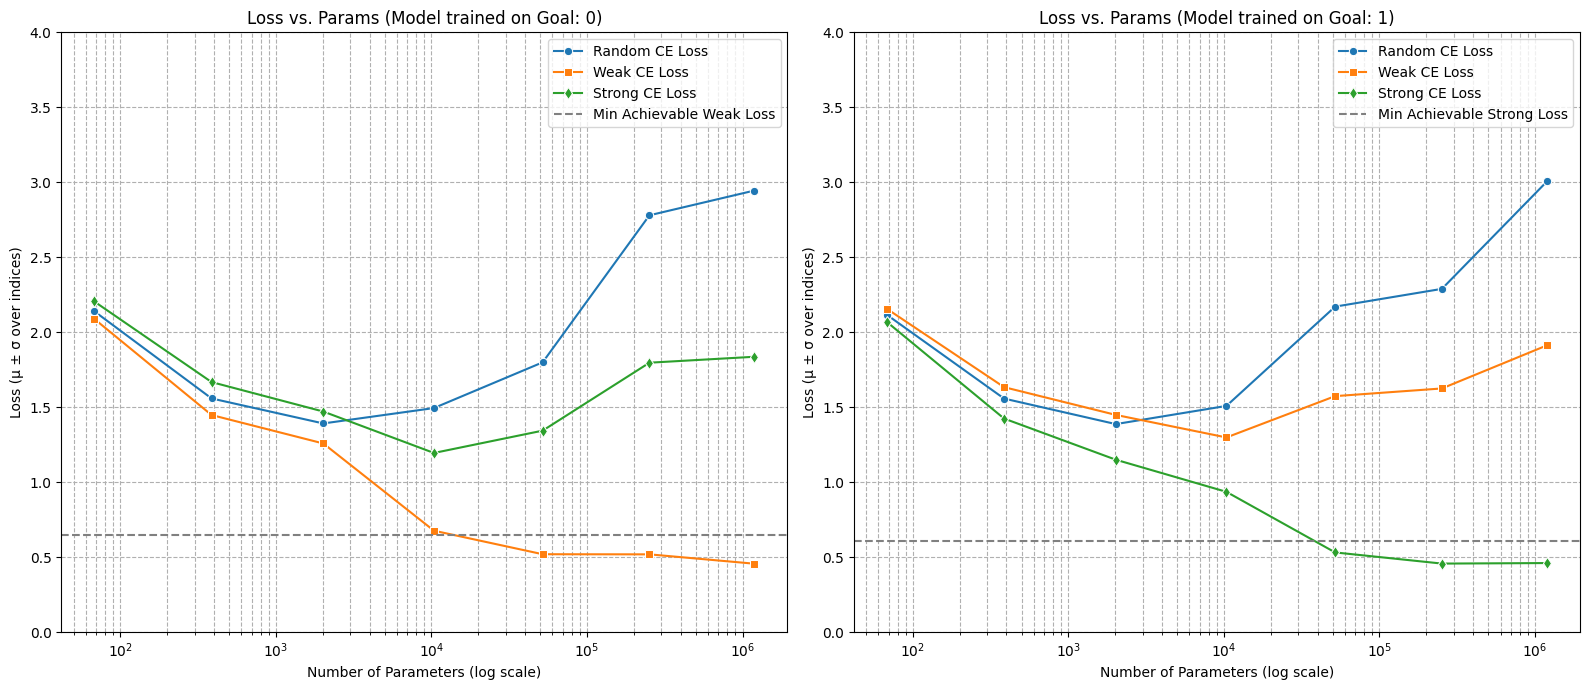

In [17]:
# project_name = "tictactoe_pretrain_forbidden_diagonal_rule_test2"
project_name = "tictactoe/tictactoe_pretraining"
plot_loss_pretrain_models(
    data_folder + "tictactoe/",
    experiment_folder,
    project_name,
    device=DEVICE,
    indices=[1],
)

In [18]:
# project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# weak_model_weak_goals = load_model(project_name, "mini", Goal.WEAK_GOAL, experiment_folder)
# strong_model_weak_goals = load_model(project_name, "medium", Goal.WEAK_GOAL, experiment_folder)
# strong_model_strong_goals = load_model(project_name, "medium", Goal.STRONG_GOAL, experiment_folder)
# quick_evaluation("Weak model weak goal", weak_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model weak goal", strong_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model strong goal", strong_model_strong_goals, tictactoe_test_data)
# strong_model_finetuned = deepcopy(strong_model_strong_goals)

# project_name = "tictactoe_playground"
# timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
# experiment_name = f"experiment_finetuning_{timestamp}"
#  # Use validation data as weak_train_data
# finetune_strong_with_weak(project_name, experiment_name, weak_model_weak_goals, strong_model_finetuned, tictactoe_weak_finetune_data, tictactoe_test_data, adapted_training_cfg)

Indices:  [0]
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_0_nano_weak_2025-05-12-12-53_lawn3fdy.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_0_micro_weak_2025-05-12-12-53_bcxjen7p.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_0_mini_weak_2025-05-12-12-53_7zx5is9k.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_0_small_weak_2025-05-12-12-53_80g6xcpz.pkl
Moving model to device:  cuda
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_0_medium_weak_2025-05-12-12-53_tlayz9my.pkl
Moving model to device:  cuda
Moving model to device:  c

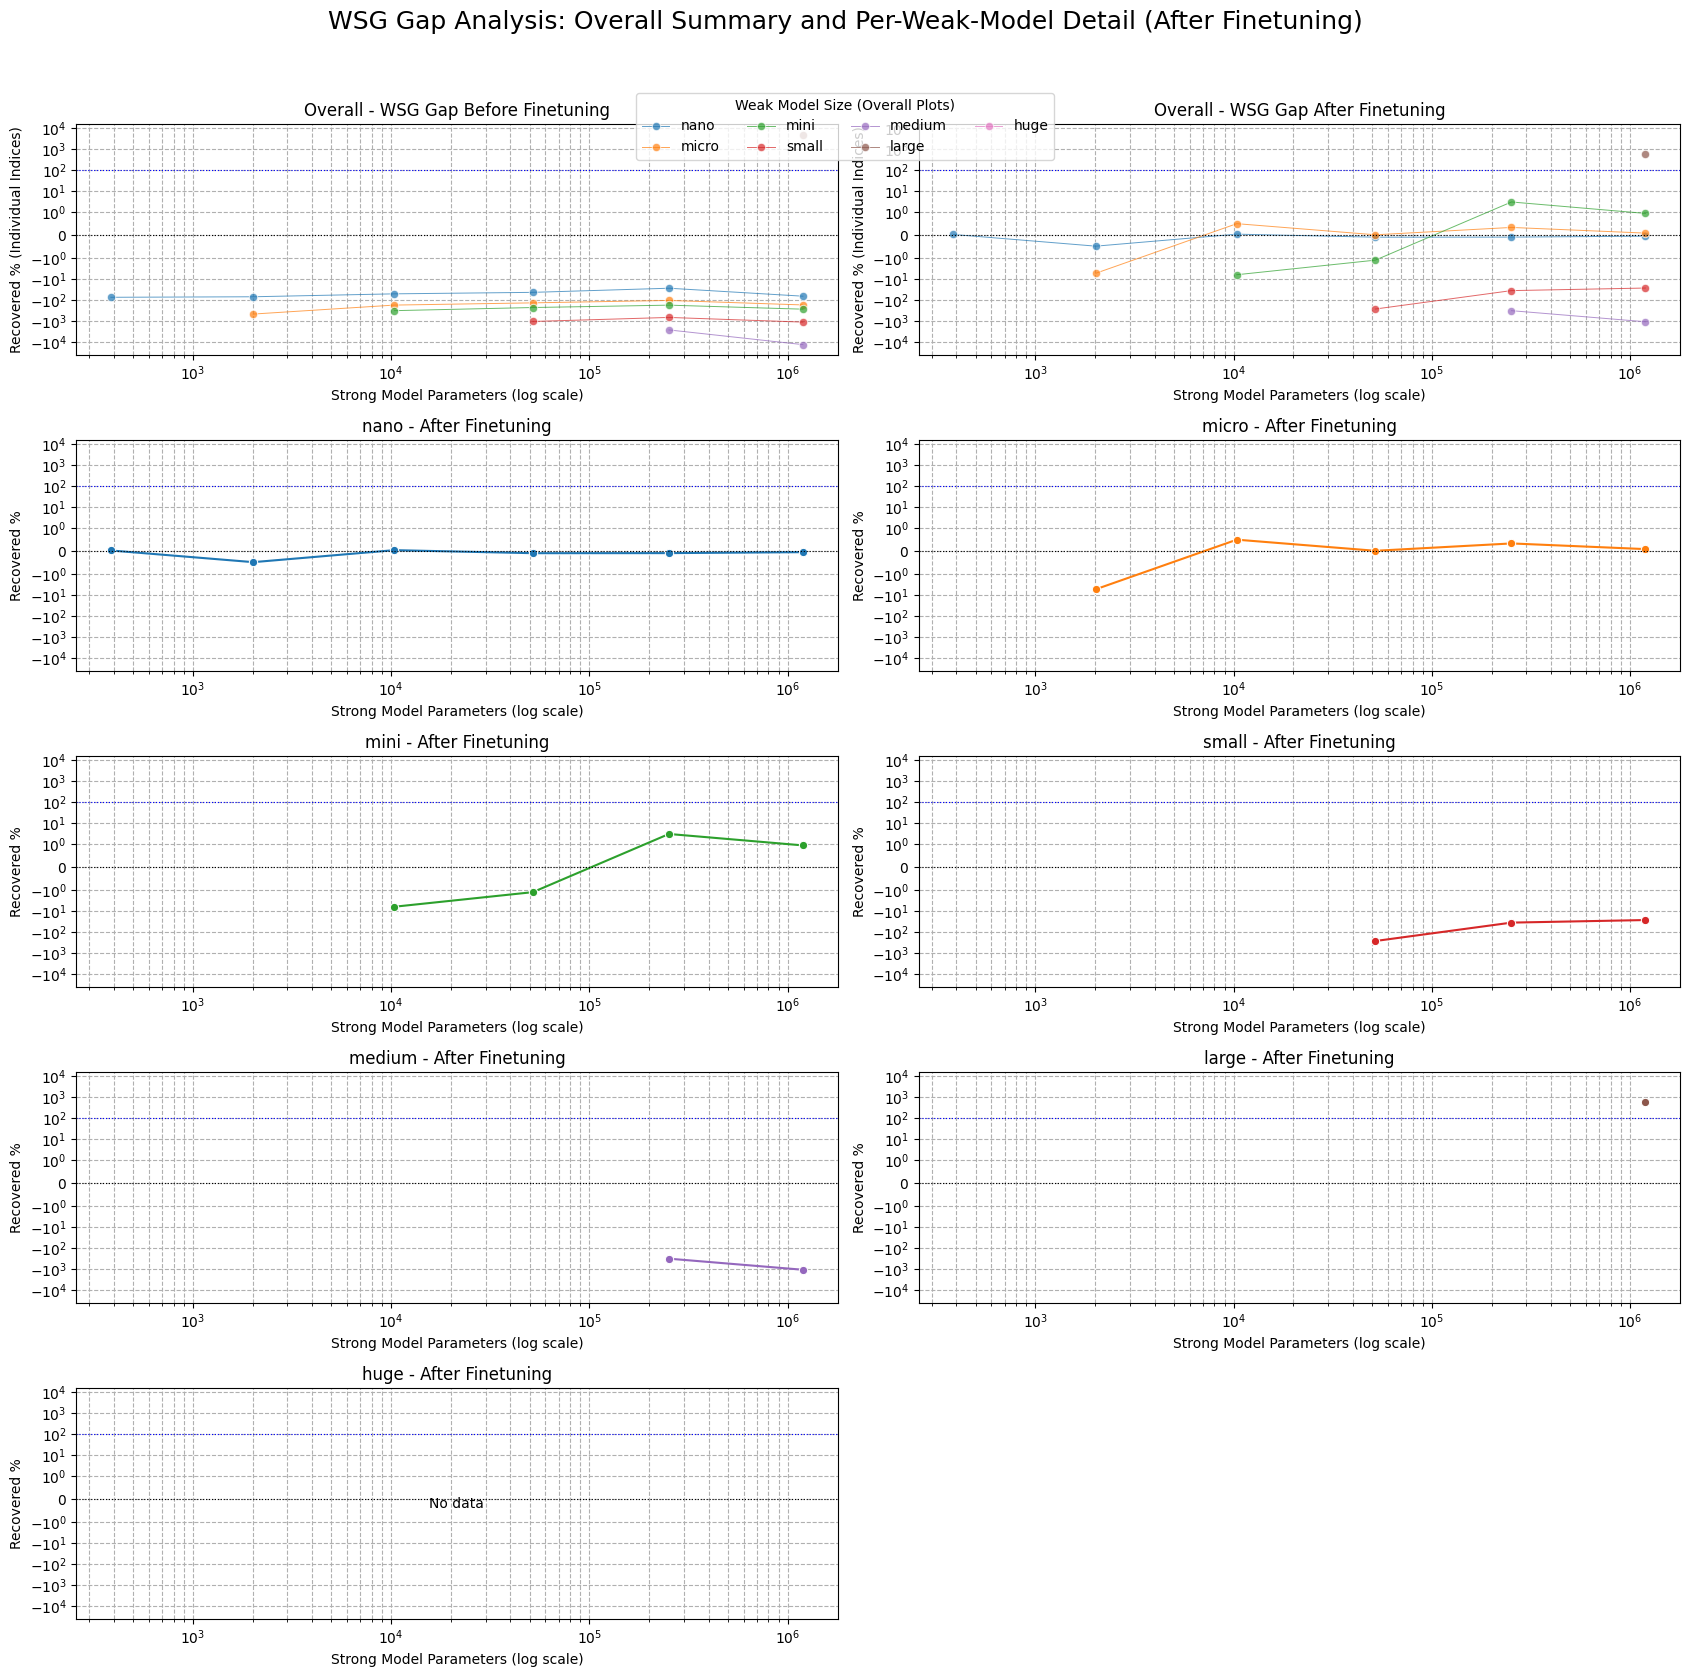

In [28]:
# pretrained_project_name_weak = "tictactoe/tictactoe_pretraining"
# pretrained_project_name_strong = "tictactoe/tictactoe_pretraining"
# finetuned_project_name = "tictactoe/tictactoe_finetuning4"
# finetuned_project_name = "tictactoe/tictactoe_finetuning_use_best_val_step4"

pretrained_project_name_weak = "tictactoe/tictactoe_pretraining"
pretrained_project_name_strong = "tictactoe/tictactoe_pretraining_random"
finetuned_project_name = "tictactoe/tictactoe_finetuning_use_best_val_step_random4"

plot_wsg_gap_finetuned_models(
    data_folder + "tictactoe/",
    experiment_folder,
    pretrained_project_name_weak,
    pretrained_project_name_strong,
    finetuned_project_name,
    device=DEVICE,
    indices=[0],
    aggregate_data=False,
)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_nano_weak_2025-05-12-13-08_dp0hcgh6.pkl
Moving model to device:  cuda
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_micro_weak_2025-05-12-13-10_hytet1nu.pkl
Moving model to device:  cuda
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_micro_strong_2025-05-12-13-24_borssshp.pkl
Moving model to device:  cuda
Moving model to device:  cuda
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_mini_weak_2025-05-12-13-11_j1nejgpj.pkl
Moving model to device:  cuda
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experiment_1_mini_strong_2025-05-12-13-25_i8dft33e.pkl
Moving model to device:  cuda
Moving model to device:  cuda
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe/tictactoe_pretraining/experimen

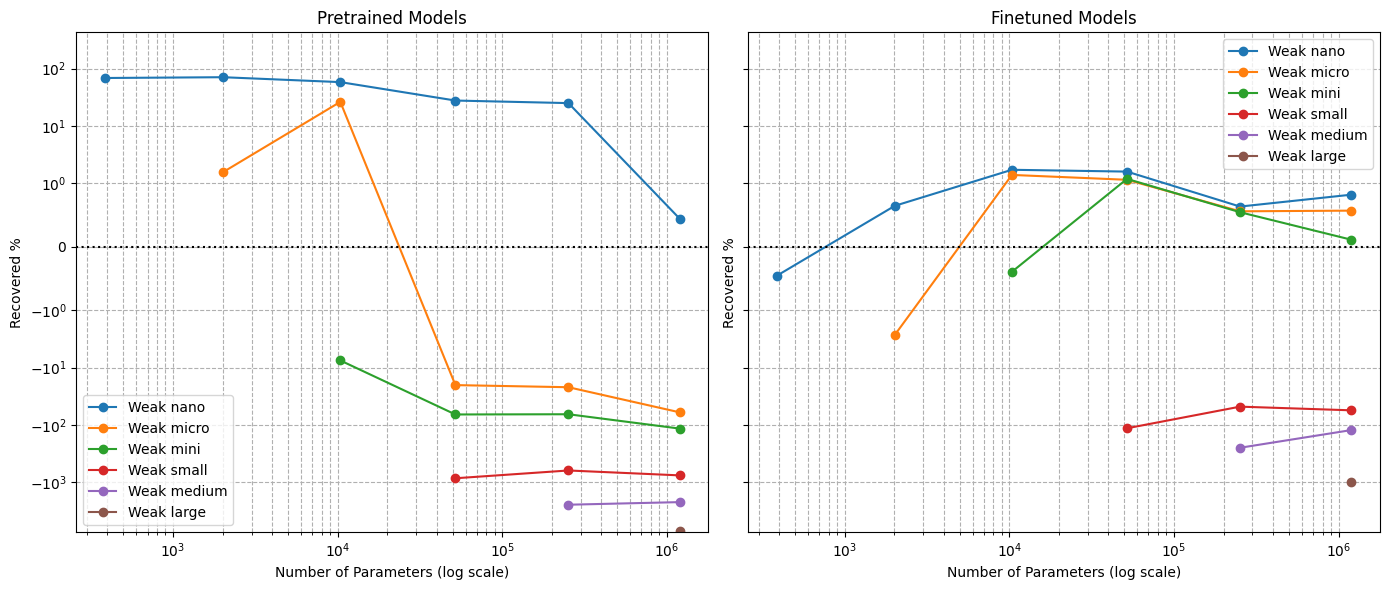

In [20]:
import os
import torch as t


# Helper: compute loss on test data
def get_weak_loss(model, test_data: TicTacToeData, n_samples: int = 20000) -> float:
    model.eval()
    with t.no_grad():
        sample = random_sample_tictactoe_data(test_data, n_samples)
        logits = model(sample.games_data)
        loss = cross_entropy(
            rearrange(logits), rearrange(sample.weak_goals_labels)
        ).item()
    return loss


def visualize_finetuning_results(
    pretrained_project_name: str,
    finetuned_project_name: str,
    experiment_folder: str,
    test_data: TicTacToeData,
    model_sizes: list,
    device: t.device,
    index: int | None,
):
    """
    For each weak_size and for every strong_size larger than weak_size,
    compute the recovered percentage:

        recovered % = (L_weak - L_model) / (L_weak - L_strong_baseline) * 100

    where:
      - L_weak: loss of the weak model (evaluated on weak_goals)
      - L_strong_baseline: loss of the pretrained strong model on the weak goal
      - L_model: loss of either the pretrained strong model (for the left plot) or the finetuned model (for the right plot)

    The x-axis is the number of parameters in the strong model (log-scaled).
    One line is drawn per weak model size, connecting datapoints for each strong size.
    Two subplots are created: left for pretrained models and right for finetuned models.
    """
    data_pretrained = {}  # { weak_size: list of (num_params, recovered %) }
    data_finetuned = {}

    for weak_size in model_sizes:
        weak_model = load_model(
            pretrained_project_name,
            weak_size,
            Goal.WEAK_GOAL,
            experiment_folder,
            device=device,
            index=index,
        )
        if not weak_model:
            print(f"Weak model of size {weak_size} not found, skipping.")
            continue

        # Get loss of weak model (using weak labels)
        L_weak = get_weak_loss(weak_model, test_data)
        data_pretrained[weak_size] = []
        data_finetuned[weak_size] = []

        for strong_size in model_sizes:
            if model_sizes.index(strong_size) <= model_sizes.index(weak_size):
                continue

            strong_model_weak_goal = load_model(
                pretrained_project_name,
                strong_size,
                Goal.WEAK_GOAL,
                experiment_folder,
                device=device,
                index=index,
            )
            strong_model_strong_goal = load_model(
                pretrained_project_name,
                strong_size,
                Goal.STRONG_GOAL,
                experiment_folder,
                device=device,
                index=index,
            )
            if not strong_model_weak_goal or not strong_model_strong_goal:
                print(f"Strong models of size {strong_size} not found, skipping.")
                continue

            num_params = count_parameters(strong_model_weak_goal)
            L_strong_baseline = get_weak_loss(strong_model_weak_goal, test_data)
            L_strong_pretrained_on_weak_goal = get_weak_loss(
                strong_model_strong_goal, test_data
            )

            # Left plot
            recovered_pretrained = (
                (L_weak - L_strong_pretrained_on_weak_goal)
                / (L_weak - L_strong_baseline)
                * 100
            )

            # Right plot
            finetuned_model = load_finetuned_model(
                finetuned_project_name,
                weak_size,
                strong_size,
                experiment_folder,
                device=device,
                index=index,
            )
            if not finetuned_model:
                print(f"Finetuned model of size {strong_size} not found, skipping.")
                continue

            L_finetuned = get_weak_loss(finetuned_model, test_data)
            recovered_finetuned = (
                (L_weak - L_finetuned) / (L_weak - L_strong_baseline) * 100
            )

            data_pretrained[weak_size].append((num_params, recovered_pretrained))
            data_finetuned[weak_size].append((num_params, recovered_finetuned))

    # Create two subplots: left for pretrained, right for finetuned.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot pretrained data.
    for weak_size, points in data_pretrained.items():
        if points:
            points.sort(key=lambda x: x[0])
            x_vals = [p[0] for p in points]
            y_vals = [p[1] for p in points]
            axes[0].plot(x_vals, y_vals, marker="o", label=f"Weak {weak_size}")
    axes[0].set_xscale("log")
    axes[0].set_xlabel("Number of Parameters (log scale)")
    axes[0].set_ylabel("Recovered %")
    axes[0].set_title("Pretrained Models")
    axes[0].legend()
    axes[0].grid(True, which="both", ls="--")

    # Plot finetuned data.
    for weak_size, points in data_finetuned.items():
        if points:
            points.sort(key=lambda x: x[0])
            x_vals = [p[0] for p in points]
            y_vals = [p[1] for p in points]
            axes[1].plot(x_vals, y_vals, marker="o", label=f"Weak {weak_size}")
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Number of Parameters (log scale)")
    axes[1].set_ylabel("Recovered %")
    axes[1].set_title("Finetuned Models")
    axes[1].legend()
    axes[1].grid(True, which="both", ls="--")

    axes[0].set_yscale("symlog", linthresh=1)
    axes[1].set_yscale("symlog", linthresh=1)
    axes[0].axhline(0, color="black", linestyle=":")
    axes[1].axhline(0, color="black", linestyle=":")

    plt.tight_layout()
    plt.show()


pretrained_project_name = "tictactoe/tictactoe_pretraining"
finetuned_project_name = "tictactoe/tictactoe_finetuning"
# pretrained_project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split_start_third_200k"
# finetuned_project_name = "finetune_sweep_test_parallel_early_top_20"
visualize_finetuning_results(
    pretrained_project_name,
    finetuned_project_name,
    experiment_folder,
    tictactoe_test_data,
    ["nano", "micro", "mini", "small", "medium", "large", "huge"],
    device=DEVICE,
    index=1,
)

In [21]:
raise Exception()

Exception: 

# Inspect model

In [ ]:
project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
model = load_model(
    project_name, "large", Goal.STRONG_GOAL, experiment_folder, device=device
)
quick_evaluation("model weak goal", model, tictactoe_test_data)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_large_strong_2025-03-17-12-30_3z524rtf.pkl
Moving model to device:  cuda
model weak goal
weak_loss:  3.2174108028411865
strong_loss:  2.530097007751465


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

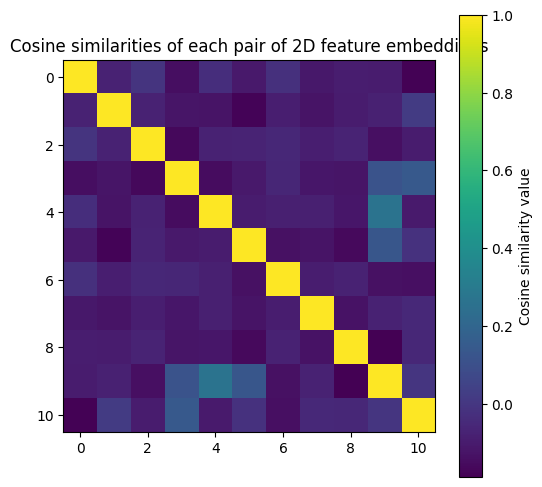

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
W = model.embed.W_E
W_normed = W / W.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix and move to CPU as a NumPy array
cosine_sim = (W_normed @ W_normed.T).detach().cpu().numpy()

im = plt.imshow(cosine_sim)
plt.title("Cosine similarities of each pair of 2D feature embeddings")
plt.gcf().set_size_inches(6, 6)

# Add a colorbar with a label
cbar = plt.colorbar(im)
cbar.set_label("Cosine similarity value")

plt.show()

In [ ]:
W.shape

torch.Size([11, 64])

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
train_sample = random_sample_tictactoe_data(tictactoe_train_data, 1)
train_logits = model(train_sample.games_data)
soft_labels = softmax(train_logits, dim=-1)
hard_labels = F.one_hot(
    train_sample.weak_goals_labels.argmax(dim=-1), num_classes=train_logits.shape[-1]
).float()

print(train_sample.weak_goals_labels.shape)
print(train_logits.shape)
print(soft_labels.shape)
print(hard_labels.shape)

torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
train_sample.weak_goals_labels

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
soft_labels.clip(0.01)

tensor([[[0.0600, 0.2873, 0.0108, 0.0100, 0.0100, 0.0776, 0.0315, 0.3437,
          0.1858, 0.0100],
         [0.2072, 0.0100, 0.0227, 0.0699, 0.0100, 0.2064, 0.1506, 0.2729,
          0.0698, 0.0100],
         [0.1674, 0.0100, 0.1112, 0.1247, 0.1391, 0.1610, 0.1112, 0.0100,
          0.1851, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.2412, 0.2433, 0.3149, 0.0100, 0.0100,
          0.1994, 0.0100],
         [0.1766, 0.0100, 0.0100, 0.0100, 0.2015, 0.2183, 0.1727, 0.0100,
          0.2303, 0.0100],
         [0.3166, 0.0100, 0.0100, 0.0100, 0.1323, 0.2899, 0.0100, 0.0100,
          0.2578, 0.0100],
         [0.3603, 0.0100, 0.0100, 0.0100, 0.0100, 0.3433, 0.0100, 0.0100,
          0.2955, 0.0100],
         [0.5842, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.4102, 0.0100],
         [0.9996, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
hard_labels

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
board = Board()
print(get_best_moves(board, Goal.WEAK_GOAL))
board.make_move(1)
print(get_best_moves(board, Goal.WEAK_GOAL))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 4, 7]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tictactoe_test_data.games_data[600]

tensor([10,  2,  0,  7,  3,  8,  1,  6,  9,  9], device='cuda:0')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tictactoe_test_data.weak_goals_labels[2]

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500,
         0.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]], device='c

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tictactoe_test_data.games_data[25][:]

NameError: name 'tictactoe_test_data' is not defined

: 

: 

: 

: 

: 

: 

In [ ]:
softmax(model(tictactoe_test_data.games_data[25][:]), dim=-1).clip(0.01)

tensor([[[0.0600, 0.2873, 0.0108, 0.0100, 0.0100, 0.0776, 0.0315, 0.3437,
          0.1858, 0.0100],
         [0.2072, 0.0100, 0.0227, 0.0699, 0.0100, 0.2064, 0.1506, 0.2729,
          0.0698, 0.0100],
         [0.1604, 0.0100, 0.1951, 0.1724, 0.0153, 0.1777, 0.0100, 0.2194,
          0.0595, 0.0100],
         [0.0100, 0.0100, 0.0672, 0.2839, 0.0138, 0.2801, 0.0100, 0.3431,
          0.0106, 0.0100],
         [0.0100, 0.0100, 0.2053, 0.1949, 0.1263, 0.0100, 0.0100, 0.2822,
          0.1904, 0.0100],
         [0.0100, 0.0100, 0.2955, 0.2582, 0.0100, 0.0100, 0.0100, 0.4357,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.2669, 0.2780, 0.0100, 0.0100, 0.4515,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9999,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.9993, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
skip_to = 0
train_dataset = TensorDataset(
    tictactoe_train_data.games_data,
    tictactoe_train_data.random_move_labels,
    tictactoe_train_data.weak_goals_labels,
    tictactoe_train_data.strong_goals_labels,
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
i = 0
for games, random_labels, weak_labels, strong_labels in train_loader:
    logits = model(games)
    probs = torch.softmax(logits, dim=-1)
    illegal_mask = (random_labels == 0).float()
    illegal_move_probs = (probs * illegal_mask).sum(dim=-1)
    avg_illegal = illegal_move_probs.mean().item()

    print(i, avg_illegal)

    i += 1
    if i > 100:
        break

0 0.002280226442962885
1 0.000929898233152926
2 0.001686390838585794
3 0.0004734809626825154
4 0.0010997230419889092
5 0.0007930731517262757
6 0.00047902631922625005
7 0.0016117574414238334
8 0.00024018592375796288
9 0.000412161200074479
10 0.0007784710614942014
11 0.00029883673414587975
12 0.0011275947326794267
13 0.00023937800142448395
14 0.0009067708742804825
15 0.0002063674182863906
16 0.0021726086270064116
17 0.0007019428303465247
18 0.0006952477269805968
19 0.0002523267758078873
20 0.00040092653944157064
21 0.0013260722626000643
22 0.00015332397015299648
23 0.0002664533967617899
24 0.00039519648998975754
25 0.0011439825175330043
26 0.0003274463233537972
27 0.000961422105319798
28 0.0016347168711945415
29 0.0005889135645702481
30 0.0002385144616710022
31 0.001433557248674333
32 0.0007983925170265138
33 0.00020917915389873087
34 0.000469208782305941
35 0.0006266026175580919
36 9.939995652530342e-05
37 0.0002688948006834835
38 9.65259168879129e-05
39 7.906727842055261e-05
40 0.00107

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

tensor([10,  8,  5,  3,  0,  1,  2,  4,  6,  7], device='cuda:0')


/homes/55/bwilop/wsg/WSG_games/wsg_games/tictactoe/analysis/visualize_game.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])


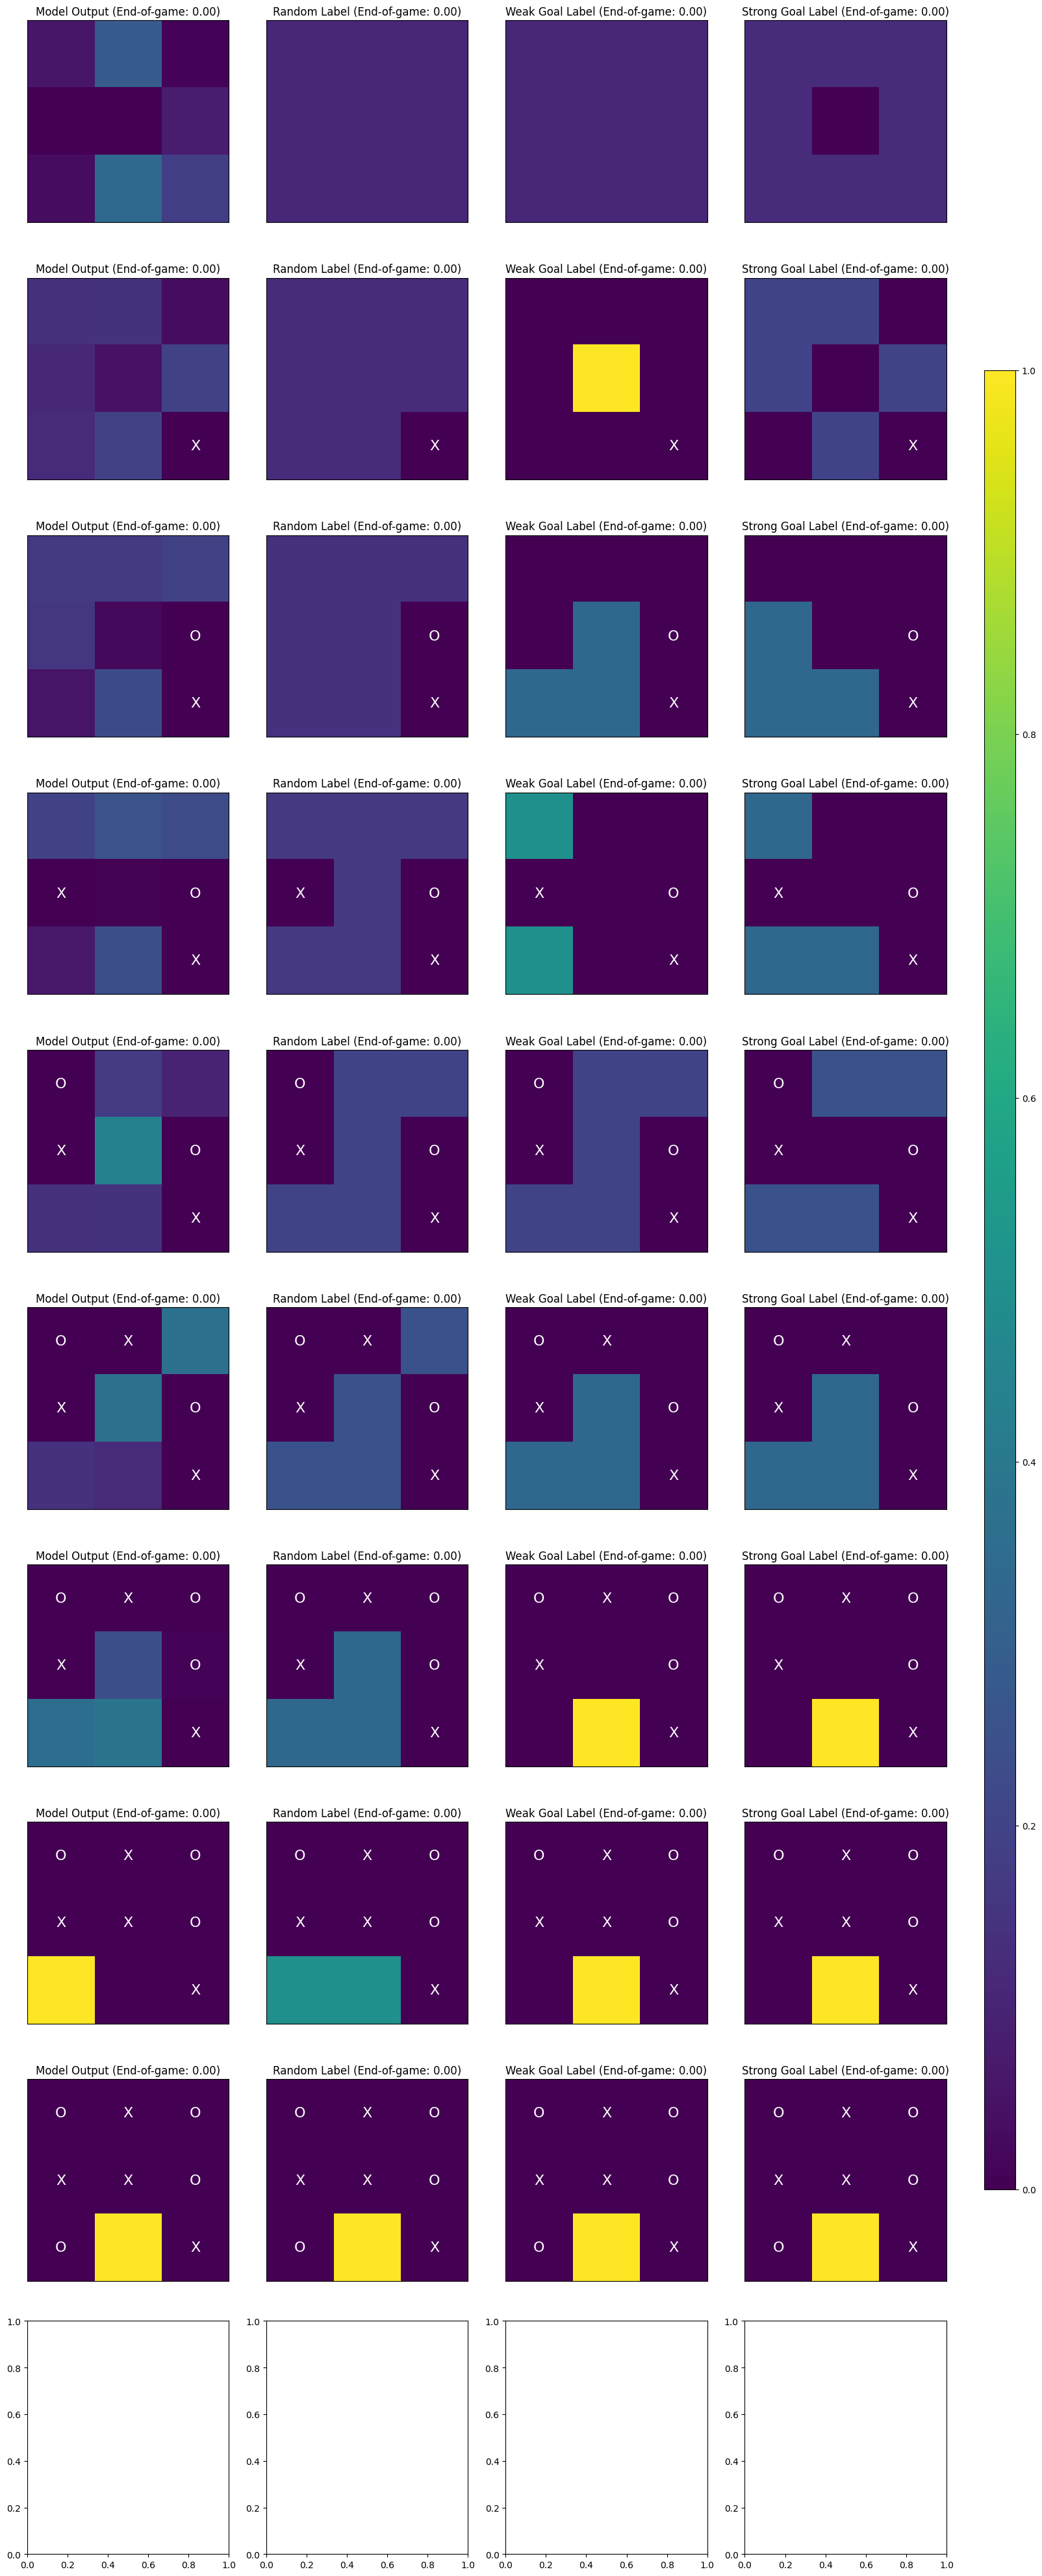

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
visualize_game(tictactoe_test_data, game_id=0, model=model)

# Sample games

In [ ]:
samples = sample_games(model, 1, 100)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
eval_model(samples)

{'_check_played_repeat_moves': 0.01,
 '_check_played_after_game_ends': 0.0,
 'inappropriate_end_state': 0.0,
 '_check_if_illegal_moves': 0.01}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
sample = samples[1]
print(sample)

[10, 7, 0, 3, 5, 8, 4, 1, 6, 2, 9]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
def check(game: list[int]) -> bool:
    board = Board()
    for move in game[1:-1]:
        print(move)
        if board.game_state == State.ONGOING:
            try:
                board.make_move(move)
            except:
                return True
        elif move == 9:
            pass
        else:
            return True
    return False


check(sample)

7
0
3
5
8
4
1
6
2


False

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
play_game(sample)
print("\nPLAY:")
board = Board()
for move in sample:
    if move not in [9, 10]:
        board.make_move(move)
        board.draw_board()
        print(".")

NameError: name 'play_game' is not defined

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
print(evals.model_vs_minimax(model, True), "\n")
print(evals._check_minimax_win_rate(model, 100))

NameError: name 'evals' is not defined

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
evals.get_error_rate(samples)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 